In [5]:
import requests
from bs4 import BeautifulSoup
import time
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import japanize_matplotlib


In [10]:
def fetch_and_save():
    headers = {"User-Agent": "Student_musashinodaigaku_2522044"}
    
    # 実際のURLに書き換えてください
    urls = {
        "2025_イベント当日": "https://www.apahotel.com/resort/plan/search.html?hoteltype=hotel_resort&resorthotel-no=172&book-checkin=2025-12-30&book-no-night=1&book-no-room=1&book-no-people=1&book-smoking=1&bc-usecorp=1", 
        "2026_通常平日": "https://www.apahotel.com/resort/plan/search.html?hoteltype=hotel_resort&resorthotel-no=172&book-checkin=2026-01-27&book-no-night=1&book-no-room=1&book-no-people=1&book-smoking=1&bc-usecorp=1"
    }
    
    conn = sqlite3.connect('hotel_analysis.db')
    cursor = conn.cursor()
    cursor.execute('DROP TABLE IF EXISTS hotel_prices')
    cursor.execute('CREATE TABLE hotel_prices (target_date TEXT, name TEXT, price INTEGER)')

    for label, url in urls.items():
        print(f"{label} のデータを取得中...")
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.content, 'html.parser')
        
        items = soup.find_all('div', class_='p-hotelList_item')
        data_to_insert = []
        
        for item in items:
            try:
                name = item.find('h2').text.strip()
                price_text = item.find('span', class_='p-hotelList_item_priceValue').text.replace(',', '')
                data_to_insert.append((label, name, int(price_text)))
            except:
                continue
        
        if data_to_insert:
            cursor.executemany('INSERT INTO hotel_prices VALUES (?, ?, ?)', data_to_insert)
            print(f" -> {len(data_to_insert)} 件保存しました")
        
        time.sleep(1.5) # 負荷配慮
    
    conn.commit()
    conn.close()
    print("DB保存が完了しました。")

# 実行
fetch_and_save()

2025_イベント当日 のデータを取得中...
2026_通常平日 のデータを取得中...
DB保存が完了しました。


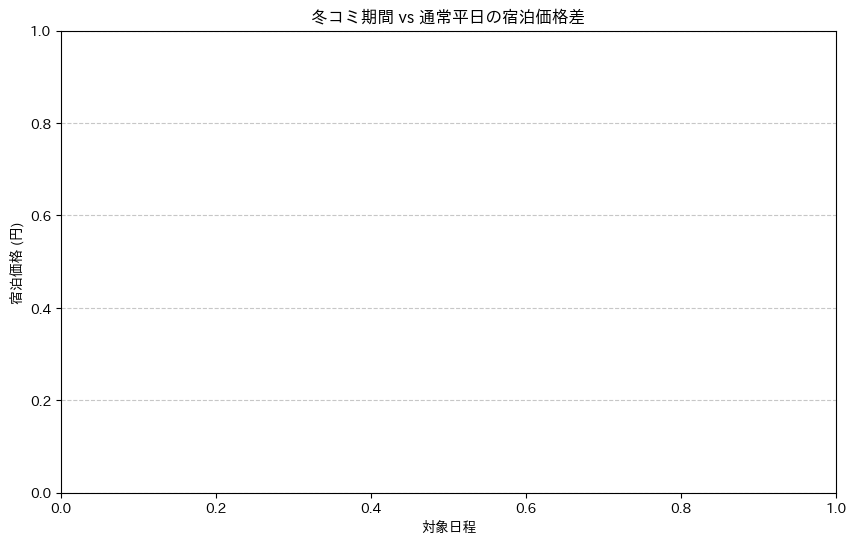

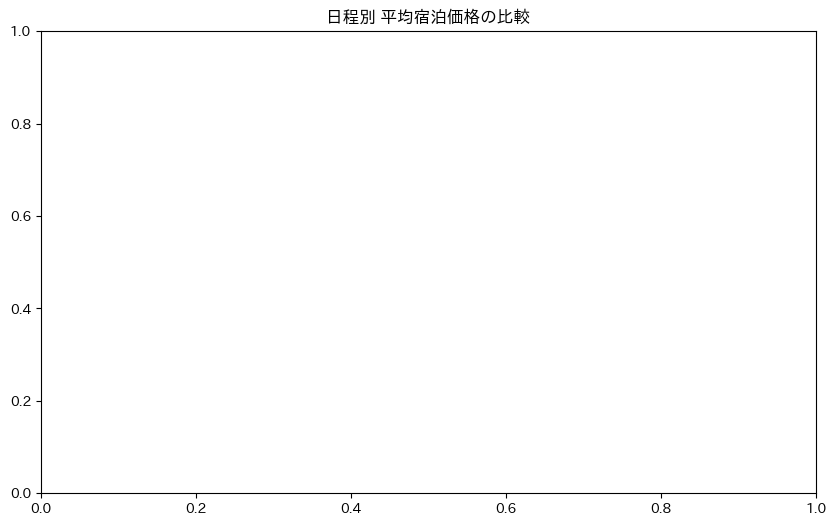

In [11]:
# DBからデータを読み込む
conn = sqlite3.connect('hotel_analysis.db')
df = pd.read_sql("SELECT * FROM hotel_prices", conn)
conn.close()

# グラフ1: イベント日と通常日の価格差（箱ひげ図）
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='target_date', y='price', palette="Set2")
plt.title('冬コミ期間 vs 通常平日の宿泊価格差')
plt.xlabel('対象日程')
plt.ylabel('宿泊価格 (円)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# グラフ2: 価格の平均比較（棒グラフ）
plt.figure(figsize=(10, 6))
avg_prices = df.groupby('target_date')['price'].mean().reset_index()
sns.barplot(data=avg_prices, x='target_date', y='price', palette="viridis")
plt.title('日程別 平均宿泊価格の比較')
plt.show()